_________

**Название проекта.** 

Прогнозирование количества заказов такси на следующий час для компании «Чётенькое такси».

_________

**Описание проекта.**  

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания с метрикой RMSE на тестовой выборке не более 48.

__________

**Задачи проекта.**  

1. Загрузить и изучить данные.  
2. Выполнить ресемплирование данных по одному часу.  
3. Провести исследовательский анализ данных.  
4. Обучить различные модели с разными гиперпараметрами, используя тестовую выборку размером 10% от исходных данных.  5. Проверить качество моделей на тестовой выборке и сделать выводы.

____________

**Исходные данные.**  

Данные находятся в файле `/datasets/taxi.csv`.  
Количество заказов указано в столбце `num_orders` (от англ. number of orders, «число заказов»).

____________

**Данное исследование разделим на несколько частей.**

- [**Шаг 1. Загрузка и изучение данных.**](#section1)  
  - [Загрузка данных.](#section1.1)  
  - [Изучение данных.](#section1.2)  
  - [Промежуточный вывод.](#section1.3)  

- [**Шаг 2. Предобработка данных.**](#section2)  
  - [Проверка данных на монотоность.](#section2.1)  
  - [Тип данных.](#section2.2)  
  - [Промежуточный вывод.](#section2.3)  

- [**Шаг 3. Исследовательский анализ данных.**](#section3)  
  - [Анализ временных закономерностей и трендов.](#section3.1)  
  - [Промежуточный вывод.](#section3.2)  

- [**Шаг 4. Подготовка данных.**](#section4)  
  - [Создание признаков.](#section4.1)  
  - [Промежуточный вывод.](#section4.2)  

- [**Шаг 5. Обучение моделей.**](#section5)  
  - [Модель LightGBM.](#section5.1)  
  - [Модель CatBoost.](#section5.2)  
  - [Модель LinearRegression.](#section5.3)  
  - [Модель DecisionTreeRegressor.](#section5.4)  
  - [Выбор модели.](#section5.5)  
  - [Промежуточный вывод.](#section5.6)  

- [**Шаг 6. Итоговый вывод.**](#section6)  

---------

In [1]:
!pip install lightgbm -q
!pip install catboost -q
!pip install phik -q
!pip install optuna -q
!pip install optuna-integration[sklearn] -q
!pip install -Uq scikit-learn
!pip install --upgrade catboost lightgbm -q

zsh:1: no matches found: optuna-integration[sklearn]


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
from phik import phik_matrix
import os
from statsmodels.tsa.seasonal import seasonal_decompose

from catboost import CatBoostRegressor
import lightgbm as lgb
import optuna

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

<a id="section1"></a>
### Загрузка и изучение данных.

<a id="section1.1"></a>
#### Загрузка данных.

In [3]:

taxi_pth1 = '/Users/ruslanminacov/Downloads/taxi.csv'
taxi_pth2 = 'https://code.s3.yandex.net/datasets/taxi.csv'

if os.path.exists(taxi_pth1):
    taxi = pd.read_csv(taxi_pth1, index_col=[0], parse_dates=[0])
elif taxi_pth2.startswith('http'):
    try:
        taxi = pd.read_csv(taxi_pth2, index_col=[0], parse_dates=[0])
    except Exception as e:
        print(f"Ошибка при загрузке taxi из URL: {e}")
else:
    print('Something is wrong with taxi.csv')



if 'taxi' in locals():
    print(f"Train loaded with shape: {taxi.shape}")
   

Train loaded with shape: (26496, 1)


<a id="section1.2"></a>
#### Изучение данных 

In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<a id="section1.3"></a>
#### Промежуточный вывод.


**Загрузка данных:**
   - Данные успешно загружены из файла `taxi.csv`. Код предусматривает два пути загрузки: локальный файл (`taxi_pth1`) и удалённый URL (`taxi_pth2`).
   - Данные загружены в DataFrame `taxi` с корректной настройкой: столбец `datetime` установлен как индекс (`index_col=[0]`) и преобразован в тип `datetime` (`parse_dates=[0]`).
   - Размер данных составляет **26496 строк и 1 столбец** (`num_orders`), что подтверждено выводом `taxi.shape`. Это указывает на почасовые или поминутные записи числа заказов такси за определённый период.

**Изучение данных**:
   - Анализ структуры данных с помощью `taxi.info()` показал:
     - Индекс: `DatetimeIndex` с записями от **01.03.2018 00:00:00** до **31.08.2018 23:50:00**, что охватывает примерно 6 месяцев.
     - Один столбец `num_orders` типа `int64` содержит количество заказов такси. Пропуски отсутствуют (`Non-Null Count: 26496`).
   - Просмотр первых строк с помощью `taxi.head(5)` показал, что данные представляют собой временной ряд с шагом в **10 минут**. Значения `num_orders` варьируются (например, от 9 до 32 заказов), что указывает на наличие колебаний, вероятно связанных с суточной или недельной сезонностью.


<a id="section2"></a>
### Предобработка данных.

<a id="section2.1"></a>
#### Проверка данных на монотоность.

In [6]:
print(taxi.index.is_monotonic)

True


<a id="section2.2"></a>
#### Тип данных.

In [7]:
taxi['num_orders'] = taxi['num_orders'].astype('int32')

In [8]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int32
dtypes: int32(1)
memory usage: 310.5 KB


<a id="section2.4"></a>
#### Промежуточный вывод.


**Проверка данных на монотонность**:
   - Проверка свойства монотонности индекса `datetime` с помощью `taxi.index.is_monotonic` показала результат `True`. Это означает, что временной индекс упорядочен строго по возрастанию (каждая последующая временная метка позже предыдущей), без нарушений хронологического порядка. 
   
**Тип данных**:
   - Столбец `num_orders` был преобразован в `int32`. Это изменение уменьшило объём памяти, занимаемой DataFrame, с примерно 414 КБ до **310.5 КБ**. 
  

### Иследовательский анализ данных.

<a id="section3.1"></a>
#### Исследовательский анализ признаков.

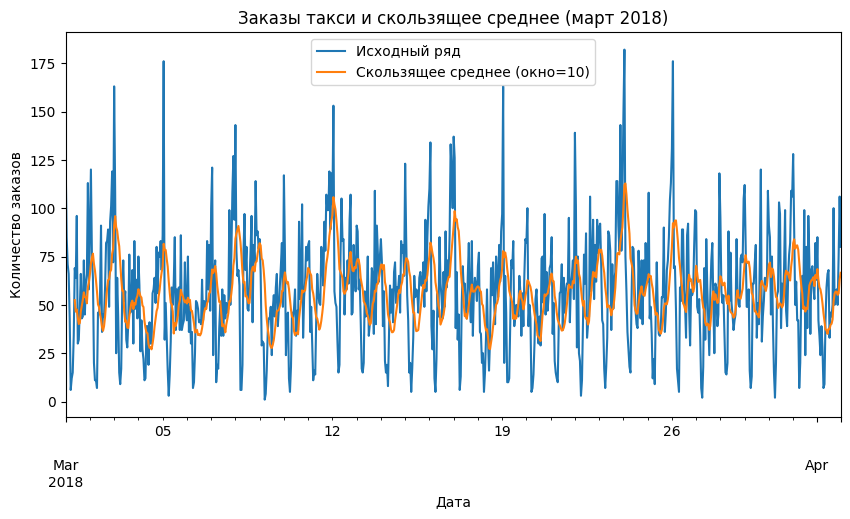

In [9]:
taxi_hour = taxi.resample('1H').sum()

plt.figure(figsize=(10, 5))

taxi_hour['2018-03-01':'2018-04-01']['num_orders'].plot(label='Исходный ряд')

taxi_hour['2018-03-01':'2018-04-01']['num_orders'].rolling(10).mean().plot(label='Скользящее среднее (окно=10)')


plt.legend()
plt.title('Заказы такси и скользящее среднее (март 2018)')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.show()

**Анализ графика: Заказы такси и скользящее среднее (март 2018)**

Описание данных и построения графика
- **Период**: График охватывает период с 1 марта 2018 года по 1 апреля 2018 года.
- **Исходный ряд** (синяя линия): Представляет собой почасовые суммы заказов (`taxi_hour['num_orders']`), показывая сырые данные с высоким уровнем шума и колебаний.
- **Скользящее среднее** (оранжевая линия): Вычислено с окном в 10 часов (`rolling(10).mean()`), сглаживая исходный ряд для выявления трендов и сезонности.

**Выводы**:
   - Исходный ряд демонстрирует значительные колебания в течение дня. Пики заказов (до 150–175) наблюдаются в определённые часы, вероятно, связанные с утренними и вечерними часами пик.
   - На графике видны повторяющиеся паттерны каждые 24 часа. Например, пики и спады повторяются ежедневно, с более высокими значениями в рабочие дни и возможным снижением в выходные.



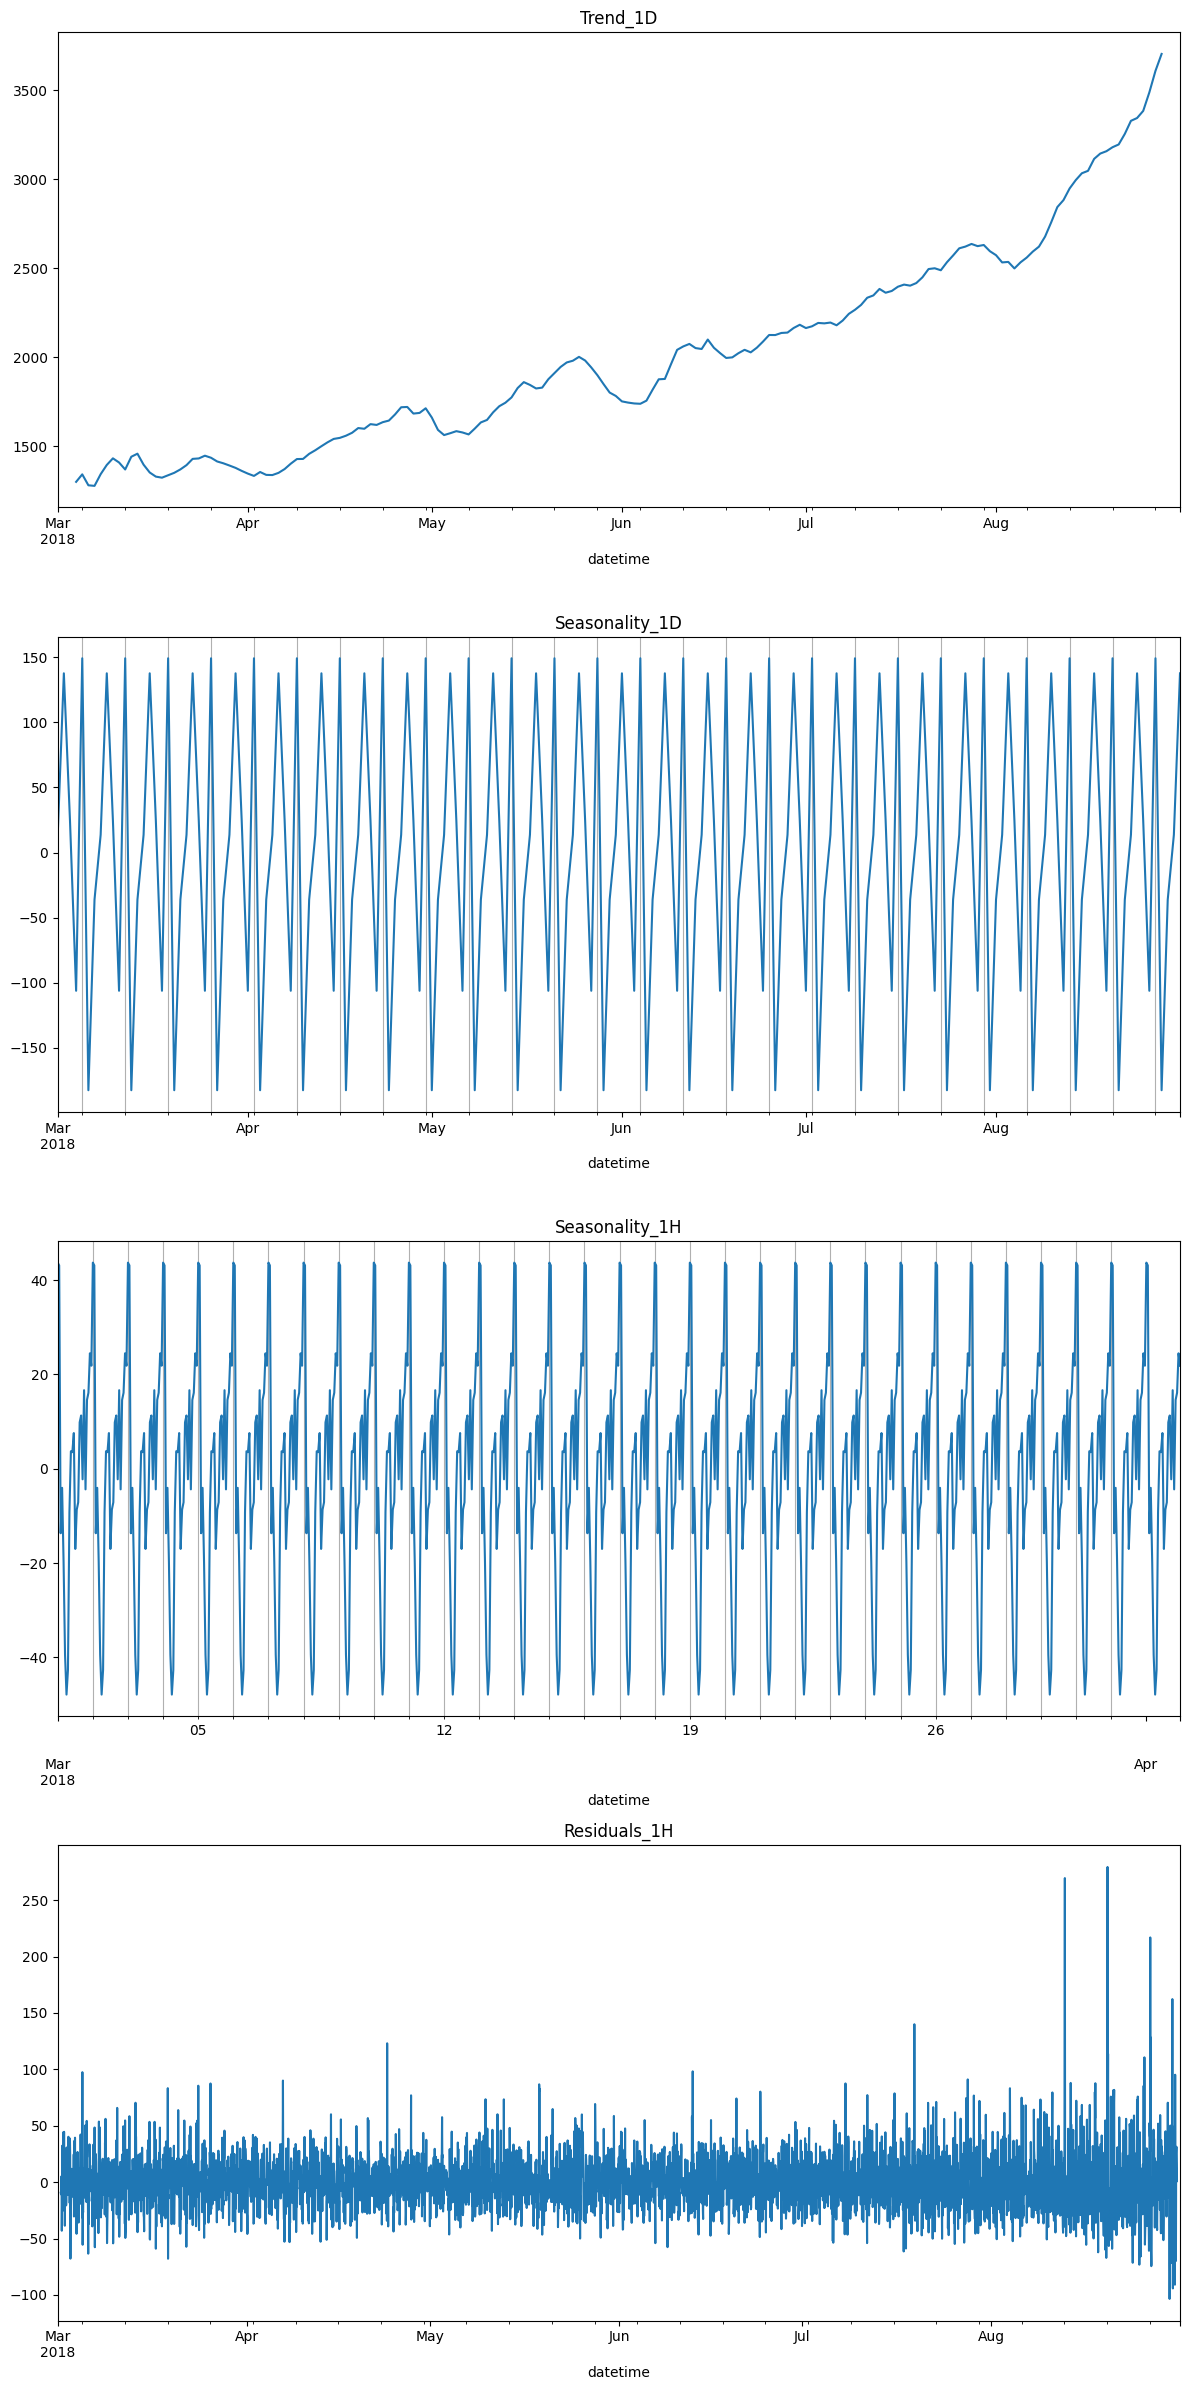

In [23]:
decomposed = seasonal_decompose(taxi.resample('1D').sum())

plt.figure(figsize=(12, 24))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend_1D')
plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality_1D')
plt.grid(True, which='minor', axis='x')

decomposed = seasonal_decompose(taxi['2018-03-01':'2018-04-01'].resample('1H').sum())
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality_1H')
plt.grid(True, which='minor', axis='x')

decomposed = seasonal_decompose(taxi.resample('1H').sum())
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals_1H')
plt.tight_layout()


**Анализ графиков**

График `Trend_1D`:
- Период: 1 марта – 31 августа 2018 года.
- Ресемплирование: До суточного интервала.
- Показывает тренд постепенного роста числа заказов с ~1000 в марте до ~3000 в августе, указывая на долгосрочный восходящий тренд, возможно, связанный с сезонным увеличением спроса (Большое количество отпусков, туристических поездок, мероприятий).

График `Seasonality_1D`:
- Период: 1 марта – 31 августа 2018 года.
- Ресемплирование: До суточного интервала.
- График дает представление о недельной сезонности. На грфике видны колебания, с двумя явными пиками, возможно, связанные с большим количством авиарейсов в начале и в конце выходных. 

График `Seasonality_1H`:
- Период: 1 марта – 1 апреля 2018 года.
- Ресемплирование: До часового интервала.
- График дает представление о суточной сезонности. C резким уменьшением заказов ночью и постепенным ростом в течение дня до пиковых значений в полночь.

График `Residuals_1H`:
- Период: 1 марта – 31 августа 2018 года.
- Ресемплирование: До часового интервала.
- График показывает количество остатков на всем временном промежутке. Можно заменить сильное увелечение количества и мощности шумов на промежутке последнего месяца, т.е. на тестовых данных, что может повлиять на точность предсказаний моделей.

<a id="section3.2"></a>
#### Промежуточный вывод.

**График: Заказы такси и скользящее среднее (март 2018)**
- **Описание данных и построения графика**:
  - **Период**: График охватывает данные с 1 марта 2018 года по 1 апреля 2018 года.
  - **Исходный ряд (синяя линия)**: Представляет почасовые суммы заказов (`taxi_hour['num_orders']`), демонстрируя сырые данные с высоким уровнем шума и колебаний.
  - **Скользящее среднее (оранжевая линия)**: Вычислено с окном в 10 часов (`rolling(10).mean()`), сглаживая исходный ряд для выявления трендов и сезонности.
- **Выводы**:
  - Исходный ряд показывает значительные суточные колебания, с пиками заказов (до 150–175), вероятно, соответствующими утренним и вечерним часам пик.
  - Наблюдаются повторяющиеся паттерны каждые 24 часа, с более высокими значениями в рабочие дни и возможным снижением в выходные, что указывает на суточную сезонность.

- **График Trend_1D**:
  - **Период**: 1 марта – 31 августа 2018 года, ресемплирован до суточного интервала.
  - **Вывод**: Показывает постепенный рост числа заказов с ~1000 в марте до ~3000 в августе, что свидетельствует о долгосрочном восходящем тренде, возможно, связанном с сезонным увеличением спроса (например, из-за отпусков, туристических поездок или мероприятий).
- **График Seasonality_1D**:
  - **Период**: 1 марта – 31 августа 2018 года, ресемплирован до суточного интервала.
  - **Вывод**: Отображает недельную сезонность с двумя явными пиками, вероятно, связанными с увеличением авиарейсов в начале и конце выходных.
- **График Seasonality_1H**:
  - **Период**: 1 марта – 1 апреля 2018 года, ресемплирован до часового интервала.
  - **Вывод**: Демонстрирует суточную сезонность с резким уменьшением заказов ночью и постепенным ростом в течение дня, достигающим пиковых значений к полуночи.
- **График Residuals_1H**:
  - **Период**: 1 марта – 31 августа 2018 года, ресемплирован до часового интервала.
  - **Вывод**: Показывает остатки, с заметным увеличением шума и амплитуды, особенно в последний месяц (тестовый период). Это может повлиять на точность предсказаний моделей, требуя дополнительной обработки или учета в моделировании.

**Итог:**
- Исследовательский анализ выявил суточную и недельную сезонность, а также долгосрочный восходящий тренд в данных заказов такси. Наличие шума в остатках последнего месяца, указывает на возможное уменьшение метрики модели на тестовой выборке.

<a id="section4"></a>
### Подготовка данных.

<a id="section4.1"></a>
#### Создание признаков.

Напишем функцию для создания признаков:

In [11]:
def make_features(data):
    data = data.resample('1H').sum()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['lag_24'] = data['num_orders'].shift(24)
    data['lag_168'] = data['num_orders'].shift(168)
    data['rolling_mean'] = data['num_orders'].shift().rolling(3).mean()
    return data.dropna()


Создадим признаки:

In [12]:
taxi = make_features(taxi)

<a id="section4.3"></a>
#### Промежуточный вывод.

Функция `make_features` была разработана для создания признаков, основываясь на результатах исследовательского анализа данных. Данные ресемплируются до почасового интервала (`resample('1H').sum()`), чтобы обеспечить единый временной шаг для анализа и моделирования.

**Были созданы признаки**:

- **month**: Добавлен для учета долгосрочного восходящего тренда, выявленного в графике `Trend_1D`, где число заказов росло с ~1000 в марте до ~3000 в августе, что указывает на сезонные изменения спроса.
- **dayofweek**: Включён для отражения недельной сезонности, подтверждённой в `Seasonality_1D` с пиками, связанными с началом и концом выходных.
- **hour**: Использован для моделирования суточной сезонности, выявленной в `Seasonality_1H`, где заказы резко снижались ночью и достигали пиков к полуночи, отражая часы пик.
- **lag_24**: Создан на основе суточного паттерна, чтобы учесть количество заказов, сделаных в идентичный временной промежуток прошлого дня.
- **lag_168**: Добавлен для учёта недельной сезонности, соответствующей 168 часам (7 дней), как показано в `Seasonality_1D` с повторяющимися циклами.
- **rolling_mean**: Включён с окном 3 часа для учитывания остатков.

После создания признаков данные очищаются от пропусков с помощью `dropna()`. Признаки `taxi = make_features(taxi)` интегрированы в основной набор данных для дальнейшего использования в обучении моделей.

<a id="section5"></a>
### Обучение моделей.

#### Модель LightGBM.

In [13]:


train, test = train_test_split(
    taxi,
    shuffle=False,
    test_size=0.1)

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)


def objective(trial):
    
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 15)
    }
    
    model = lgb.LGBMRegressor(
        num_leaves=params['num_leaves'],
        max_depth=params['max_depth'],
        verbose = -1
    )
    model.fit(X_train, y_train)
    
    cv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring=rmse_scorer,
        n_jobs=1,
        cv=cv
    )
    
    rmses = -scores.mean()
    return rmses

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  

# Вывод результатов
print("Лучшие параметры:", study.best_params)
print("Наименьшее RMSE на кросс-валидации:", study.best_value)


[I 2025-06-22 12:35:41,261] A new study created in memory with name: no-name-40f5508d-d643-451d-9c44-f1118e887486
[I 2025-06-22 12:35:41,479] Trial 0 finished with value: 23.855366484287174 and parameters: {'num_leaves': 21, 'max_depth': 8}. Best is trial 0 with value: 23.855366484287174.
[I 2025-06-22 12:35:41,807] Trial 1 finished with value: 24.62883065422216 and parameters: {'num_leaves': 66, 'max_depth': 15}. Best is trial 0 with value: 23.855366484287174.
[I 2025-06-22 12:35:42,112] Trial 2 finished with value: 24.40963395649216 and parameters: {'num_leaves': 82, 'max_depth': 11}. Best is trial 0 with value: 23.855366484287174.
[I 2025-06-22 12:35:42,394] Trial 3 finished with value: 24.14431046048605 and parameters: {'num_leaves': 69, 'max_depth': 8}. Best is trial 0 with value: 23.855366484287174.
[I 2025-06-22 12:35:42,530] Trial 4 finished with value: 23.48453533039872 and parameters: {'num_leaves': 46, 'max_depth': 4}. Best is trial 4 with value: 23.48453533039872.
[I 2025-0

Лучшие параметры: {'num_leaves': 99, 'max_depth': 3}
Наименьшее RMSE на кросс-валидации: 23.442070653412244


**Модель LightGBM:**
- Лучшие параметры: 
    - `num_leaves`: 99, 
    - `max_depth`: 3
- Наименьшее RMSE на кросс-валидации: 23.442070653412244

<a id="section5.2"></a>
#### Модель CatBoost.

In [15]:

def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 3, 10),    
        'l2_leaf_reg':trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 1, 20)
    }
    
    model = CatBoostRegressor(
        depth=params['depth'],
        l2_leaf_reg=params['l2_leaf_reg'],
        min_data_in_leaf=params['min_data_in_leaf'],
        verbose=0 
    )
    
    model.fit(X_train, y_train)
    
    cv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring=rmse_scorer,
        n_jobs=1,
        cv=cv
    )
    
    rmses = -scores.mean()

    return rmses


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Вывод результатов
print("Лучшие параметры:", study.best_params)
print("Наименьшее RMSE на кросс-валидации:", study.best_value)



[I 2025-06-22 12:36:08,483] A new study created in memory with name: no-name-78f733e2-4bd1-47dd-b939-a91fce05dc0f
[I 2025-06-22 12:36:15,523] Trial 0 finished with value: 24.128370636747782 and parameters: {'depth': 7, 'l2_leaf_reg': 0.7569695622639417, 'min_data_in_leaf': 13}. Best is trial 0 with value: 24.128370636747782.
[I 2025-06-22 12:36:21,192] Trial 1 finished with value: 24.031378246959754 and parameters: {'depth': 6, 'l2_leaf_reg': 0.009138598385374811, 'min_data_in_leaf': 1}. Best is trial 1 with value: 24.031378246959754.
[I 2025-06-22 12:36:43,643] Trial 2 finished with value: 24.638478504077305 and parameters: {'depth': 9, 'l2_leaf_reg': 1.488043244416199, 'min_data_in_leaf': 6}. Best is trial 1 with value: 24.031378246959754.
[I 2025-06-22 12:36:47,008] Trial 3 finished with value: 23.594387929761034 and parameters: {'depth': 3, 'l2_leaf_reg': 0.005789833248823435, 'min_data_in_leaf': 5}. Best is trial 3 with value: 23.594387929761034.
[I 2025-06-22 12:36:56,400] Trial 

Лучшие параметры: {'depth': 4, 'l2_leaf_reg': 7.274988812201555, 'min_data_in_leaf': 8}
Наименьшее RMSE на кросс-валидации: 23.457683612301615


**Модель CatBoost:**
- Лучшие параметры: 
   - `depth`: 4,
   - `l2_leaf_reg`: 7.274988812201555,
   - `min_data_in_leaf`: 8
- Наименьшее RMSE на кросс-валидации: 23.457683612301615


<a id="section5.3"></a>
#### Модель LinearRegression.

In [16]:

def objective(trial):
    params = {
        'model_type': trial.suggest_categorical('model_type', ['linear', 'ridge']),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'alpha': trial.suggest_float('alpha', 0.001, 10, log=True) 
    }


    if params['model_type'] == 'linear':
        model = LinearRegression(
            fit_intercept=params['fit_intercept']
        )
    else:  
        model = Ridge(
            alpha=params['alpha'],
            fit_intercept=params['fit_intercept']
        )
        
    model.fit(X_train, y_train)

    cv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring=rmse_scorer,
        n_jobs=1,
        cv=cv
    )

    rmses = -scores.mean()
    
    
    return rmses

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)


# Вывод результатов
print("Лучшие параметры:", study.best_params)
print("Наименьшее RMSE на кросс-валидации:", study.best_value)



[I 2025-06-22 12:39:03,240] A new study created in memory with name: no-name-5b070721-f1d3-4d9a-a8ae-507828fa38f3
[I 2025-06-22 12:39:03,366] Trial 0 finished with value: 23.59631648264501 and parameters: {'model_type': 'ridge', 'fit_intercept': True, 'alpha': 0.1533071429006806}. Best is trial 0 with value: 23.59631648264501.
[I 2025-06-22 12:39:03,558] Trial 1 finished with value: 23.422996415911275 and parameters: {'model_type': 'linear', 'fit_intercept': False, 'alpha': 0.0035613781416456375}. Best is trial 1 with value: 23.422996415911275.
[I 2025-06-22 12:39:03,671] Trial 2 finished with value: 23.422996415911275 and parameters: {'model_type': 'linear', 'fit_intercept': False, 'alpha': 0.0038448859877409157}. Best is trial 1 with value: 23.422996415911275.
[I 2025-06-22 12:39:03,753] Trial 3 finished with value: 23.5969235936206 and parameters: {'model_type': 'ridge', 'fit_intercept': True, 'alpha': 0.003302803911785771}. Best is trial 1 with value: 23.422996415911275.
[I 2025-06

Лучшие параметры: {'model_type': 'ridge', 'fit_intercept': False, 'alpha': 6.657693169712142}
Наименьшее RMSE на кросс-валидации: 23.42291690625941


**Модель LinearRegression:**
- Лучшие параметры: 
  - `model_type`: 'ridge', 
  - `fit_intercept`: False, 
  - `alpha`: 6.657693169712142
- Наименьшее RMSE на кросс-валидации: 23.42291690625941



<a id="section5.4"></a>
#### Модель DecisionTreeRegressor.

In [17]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20)
    }
    
    model = DecisionTreeRegressor()
    
   
    cv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring=rmse_scorer,
        n_jobs=1,
        cv=cv
    )

    rmses = -scores.mean()
    
    
    return rmses

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)


# Вывод результатов
print("Лучшие параметры:", study.best_params)
print("Наименьшее RMSE на кросс-валидации:", study.best_value)


[I 2025-06-22 12:39:05,094] A new study created in memory with name: no-name-17c5f0e3-6bb7-44b3-b680-b8c0b7aa38c7
[I 2025-06-22 12:39:05,261] Trial 0 finished with value: 32.95674685734639 and parameters: {'max_depth': 6, 'min_samples_leaf': 16, 'min_samples_split': 12}. Best is trial 0 with value: 32.95674685734639.
[I 2025-06-22 12:39:05,407] Trial 1 finished with value: 32.99912606135633 and parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 11}. Best is trial 0 with value: 32.95674685734639.
[I 2025-06-22 12:39:05,546] Trial 2 finished with value: 32.6619757880277 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2}. Best is trial 2 with value: 32.6619757880277.
[I 2025-06-22 12:39:05,663] Trial 3 finished with value: 33.449653743358446 and parameters: {'max_depth': 15, 'min_samples_leaf': 9, 'min_samples_split': 18}. Best is trial 2 with value: 32.6619757880277.
[I 2025-06-22 12:39:05,801] Trial 4 finished with value: 32.829825933

Лучшие параметры: {'max_depth': 13, 'min_samples_leaf': 13, 'min_samples_split': 4}
Наименьшее RMSE на кросс-валидации: 32.598050680251944


**Модель DecisionTreeRegressor:**
- Лучшие параметры: 
    - `max_depth`: 13, 
    - `min_samples_leaf`: 13, 
    - `min_samples_split`: 4
- Наименьшее RMSE на кросс-валидации: 32.598050680251944

<a id="section5.5"></a>
#### Выбор модели.

На основе кросс-валидационного RMSE, выделим три модели показавшие очень близкое значение метрики. Заметим, что модели LGBM и Catboost более склонны к переобучению, поэтому в качестве финальной модели для тестирования на тестовых данных выберем линейную модель Ridge.

In [18]:

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

final_model = Ridge(alpha=9.843372548195404, fit_intercept=False)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE на тестовой выборке: {rmse_test}")

RMSE на тестовой выборке: 35.933136987987055


**RMSE на тестовой выборке:** 35.933136987987055

<a id="section5.6"></a>
#### Промежуточный вывод.

**Анализ моделей**
- **Модель LightGBM**:
  - **Параметры**: `num_leaves=99`, `max_depth=3`.
  - **RMSE на кросс-валидации**: 23.442.
  - Высокое значение `num_leaves` может способствовать переобучению, несмотря на низкую глубину.
- **Модель CatBoost**:
  - **Параметры**: `depth=4`, `l2_leaf_reg=7.274`, `min_data_in_leaf=8`.
  - **RMSE на кросс-валидации**: 23.458.
  - Регуляризация (`l2_leaf_reg`) и минимальное число объектов в листе снижают риск переобучения, но модель близка по метрике к другим.
- **Модель LinearRegression (Ridge)**:
  - **Параметры**: `model_type='ridge'`, `fit_intercept=False`, `alpha=6.657`.
  - **RMSE на кросс-валидации**: 23.423.
  - Регуляризация L2 обеспечивает стабильность, делая модель менее склонной к переобучению.
- **Модель DecisionTreeRegressor**:
  - **Параметры**: `max_depth=13`, `min_samples_leaf=13`, `min_samples_split=4`.
  - **RMSE на кросс-валидации**: 32.598.
  - Высокая глубина и низкие ограничения на листья указывают на склонность к переобучению, что отражено в наихудшем RMSE.

**Выбор модели**
На основе кросс-валидационного RMSE (23.423–23.458) три модели (LightGBM, CatBoost, Ridge) показали близкие результаты. Однако LightGBM и CatBoost, как градиентные бустинговые модели, более склонны к переобучению из-за сложной структуры деревьев. Поэтому для финального тестирования выбрана модель Ridge с параметрами `alpha=9.843`, `fit_intercept=False`, которая обеспечила баланс между точностью и устойчивостью. 

**Тестирование модели**
- RMSE на тестовой выборке: 35.933.
- Увеличение RMSE на тестовой выборке (с 23.423 на кросс-валидации до 35.933 на тесте) по сравнению с кросс-валидационными результатами модели Ridge связано с шумами, выявленными на этапе исследовательского анализа. Шумы в тестовом наборе могли быть вызваны внезапными всплесками заказов (например, из-за праздников, событий или изменений в спросе. Также с увелечением сезонного спроса, увеличиваетмя и число отмененных и перенесенных рейсов, что также вызавает дополнительное увелечение шумов в последний месяц.

<a id="section6"></a>
### Итоговый вывод.

**Выполненные шаги**:
- Данные успешно загружены из файла `taxi.csv` (26496 записей), индекс `datetime` настроен как временной ряд, пропуски отсутствуют.
- Выполнено ресемплирование до почасового интервала, подтверждена монотонность индекса, тип `num_orders` оптимизирован до `int32` для снижения памяти.
- Выявлены суточная и недельная сезонность, восходящий тренд и шум, особенно в последнем месяце.
- Разработана функция `make_features` с временными признаками (`month`, `day`, `dayofweek`, `hour`), лагами и скользящим средним, обеспечивающая гибкость для моделирования.

**Исследовательский анализ данных**
Исследовательский анализ данных проводился с использованием графиков и разложения временного ряда с помощью `seasonal_decompose`, что позволило выявить ключевые закономерности:
- **Тренд увеличения заказов к лету**: График `Trend_1D`, построенный на данных с 1 марта по 31 августа 2018 года с суточным ресемплированием, показал постепенный рост числа заказов с ~1000 в марте до ~3000 в августе. Этот восходящий тренд, вероятно, связан с сезонным увеличением туристической активности, ростом отпусков и проведением летних мероприятий, что характерно в в тёплый период года.
- **Суточная сезонность**: Анализ графика `Seasonality_1H` за период с 1 марта по 1 апреля 2018 года с почасовым ресемплированием выявил чёткие суточные циклы. Заказы резко снижались ночью (минимальные значения), постепенно нарастали в течение дня и достигали пиков к полуночи, что соответствует вечерним часам пик, связанным с расписанием авиарейсов и активностью пассажиров.
- **Недельная сезонность**: График `Seasonality_1D` за весь период (1 марта – 31 августа 2018 года) продемонстрировал недельные колебания с двумя выраженными пиками, вероятно, приходящимися на начало и конец выходных. Это может быть обусловлено увеличением авиарейсов в эти дни, а также изменением поведения пассажиров (например, вылеты в пятницу и возвращения в воскресенье).
- **Причины шумов**: График `Residuals_1H`, охватывающий весь период с почасовым ресемплированием, показал значительное увеличение шума и амплитуды остатков, особенно в последний месяц (август 2018 года, соответствующий тестовому набору). Это может быть вызвано неучтёнными факторами, такими как аномально высокие заказы из-за праздников, массовых событий, увеличения числа отмененных и перенесенных рейсов.


**Обучение моделей**:
- **Обучение и тестирование моделей**: Были протестированы линейная модели, дерево решений и модели градиентного бустинга с использованием библиотеки `Optuna` для оптимизации гиперпараметров и `cross_val_score` для кросс-валидации. Данные ресемплированы до почасового интервала, а тестовый набор составил 10% от исходных данных.
- **Выбор модели**: Оптимальной оказалась модель Ridge с параметрами alpha=9.843, fit_intercept=False, показавшая RMSE 23.423 на кросс-валидации.
- **Тестирование модели**: RMSE на тестовой выборке: 35.933
- **Причина увелечения метрики**: Увеличение RMSE на тестовой выборке (с 23.423 на кросс-валидации до 35.933 на тесте) по сравнению с кросс-валидационными результатами модели Ridge связано с шумами, выявленными на этапе исследовательского анализа.
- **Итог**: Несмотря на увелечение метрики RMSE на тестовом наборе данных, модель Ridge показала значение метрики RMSE = 35.933 <= 48, что выполняет требования поставленной задачи.


